# Instacart orders 

Exploratory data analysis of 
[3M Instacart orders](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2)
[dataset](https://www.instacart.com/datasets/grocery-shopping-2017).

See also [data dictionary](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b).

In [1]:
import pandas as pd
import numpy as np
import glob
import os 
import matplotlib.pyplot as plt
%matplotlib inline

DATASET_LOCATION = '../big_datasets/instacart_2017_05_01'


# Data prep

In [2]:
def load_data(path):
    """ Return a dictionary mapping each table (eg orders) to its df.
    """
    paths = glob.glob(os.path.join(path, "*.csv"))
    frames = {}
    
    for path in paths:
        df_name = path.split("\\")[-1][:-4] # without '.csv'
        if df_name == 'order_products__prior': # 500MB, skip it for now
            continue
        df = pd.read_csv(path, header=0)
        frames[df_name] = df
        
    return frames

frames = load_data(DATASET_LOCATION)

print('data frames available:') 
print(
    '\n'.join(
        '--- {} ---\nshape {}\ncolumns {}'.format(
            n, df.shape, list(df.columns)
        ) for n, df in frames.items()
    )
)


data frames available:
--- aisles ---
shape (134, 2)
columns ['aisle_id', 'aisle']
--- departments ---
shape (21, 2)
columns ['department_id', 'department']
--- orders ---
shape (3421083, 7)
columns ['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']
--- order_products__train ---
shape (1384617, 4)
columns ['order_id', 'product_id', 'add_to_cart_order', 'reordered']
--- products ---
shape (49688, 4)
columns ['product_id', 'product_name', 'aisle_id', 'department_id']


In [3]:
# add some potentially useful columns and frames
frames['orders']['order_hour_of_week'] = frames['orders']['order_dow'] * 24 + frames['orders']['order_hour_of_day']

frames['order_products_enriched'] = (
    frames['order_products__train']
    .join(frames['orders'].set_index('order_id'), on='order_id')
    .join(frames['products'].set_index('product_id'), on='product_id')
    .join(frames['aisles'].set_index('aisle_id'), on='aisle_id')
    .join(frames['departments'].set_index('department_id'), on='department_id')
)
frames['order_products_enriched'].head()


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_hour_of_week,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,106,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,112108,train,4,4,10,9.0,106,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,112108,train,4,4,10,9.0,106,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,112108,train,4,4,10,9.0,106,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,112108,train,4,4,10,9.0,106,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods


# Ordering over time

- Customers seem to order mostly during daytime. 
- Hourly volume of orders is 25% higher in the weekend (assuming `order_dow` of zero means Saturday).
- Weekend customers also seem to be less frequent customers.


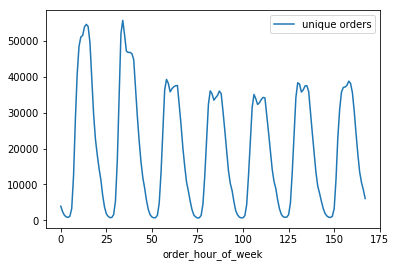

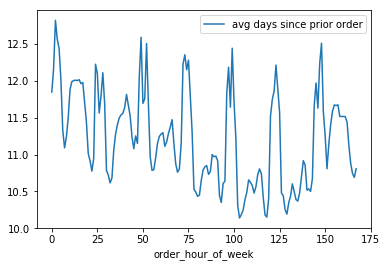

In [4]:
# histogram of orders by day of week + time of day
(
    frames['orders']
    .groupby('order_hour_of_week')
    .agg({'order_id':pd.Series.nunique})
    .rename({'order_id':'unique orders'}, axis='columns')
    .plot()
)

(
    frames['orders']
    .groupby('order_hour_of_week')
    .agg({'days_since_prior_order':np.mean})
    .rename({'days_since_prior_order':'avg days since prior order'}, axis='columns')
    .plot()
)

# Most-ordered dept and products

- Departments: produce, eggs, beverages
- Products: bananas, strawberries
- Rank of departments (by volume of orders) is constant throughout the day and the week.

In [5]:
# top 5 most-ordered dept
(
    frames['order_products_enriched']
    .groupby(['department'])
    .agg({'order_id':pd.Series.nunique})
    .rename({'order_id':'orders'},axis='columns')
    .sort_values(['orders'], ascending=False)
    .head(5)
)

,orders
department,
produce,96927
dairy eggs,87400
beverages,61482
snacks,57302
frozen,51071


In [6]:

# top 5 most-ordered products
(
    frames['order_products_enriched']
    .groupby(['product_name'])
    .agg({'order_id':pd.Series.nunique})
    .rename({'order_id':'orders'},axis='columns')
    .sort_values(['orders'], ascending=False)
    .head(5)
)

,orders
product_name,
Banana,18726
Bag of Organic Bananas,15480
Organic Strawberries,10894
Organic Baby Spinach,9784
Large Lemon,8135


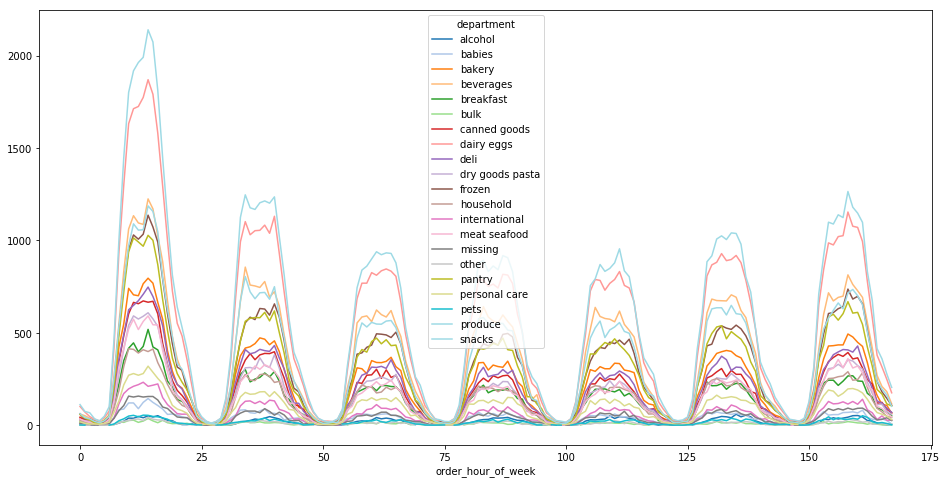

In [7]:
# unique orders by hour of day, split by dept
(
    frames['order_products_enriched']
    .groupby(['order_hour_of_week','department'])
    .agg({'order_id':pd.Series.nunique})
    .unstack() # unpivot
    .xs('order_id', axis=1, drop_level=True) # remove leftover multi index
    .plot(figsize=(16, 8), colormap=plt.get_cmap('tab20')) # use custom cmap so we can distinguish the 20 dept apart
)
